# Task 2 Evaluation

This notebook contains the evaluation for Task 1 of the TREC Fair Ranking track.

## Setup

We begin by loading necessary libraries:

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import binpickle

Set up progress bar and logging support:

In [2]:
from tqdm.auto import tqdm
tqdm.pandas(leave=False)

In [3]:
import sys, logging
logging.basicConfig(level=logging.INFO, stream=sys.stderr)
log = logging.getLogger('task1-eval')

Set up the RNG:

In [4]:
import seedbank
seedbank.initialize(20220101)
rng = seedbank.numpy_rng()

INFO:seedbank:initialized root seed SeedSequence(
    entropy=20220101,
)


Import metric code:

In [5]:
import metrics
from trecdata import scan_runs

And finally import the metric itself:

In [6]:
metric = binpickle.load('task2-eval-metric.bpk')

## Importing Data



Let's load the runs now:

In [7]:
runs = pd.DataFrame.from_records(row for (task, rows) in scan_runs() if task == 2 for row in rows)
runs

INFO:trecdata:scanning runs\1step_pair.gz
INFO:trecdata:scanning runs\1step_pair_list.gz
INFO:trecdata:scanning runs\2step_pair.gz
INFO:trecdata:scanning runs\2step_pair_list.gz
INFO:trecdata:scanning runs\pl_control_0.6.gz
INFO:trecdata:scanning runs\pl_control_0.8.gz
INFO:trecdata:scanning runs\pl_control_0.92.gz
INFO:trecdata:scanning runs\PL_IRLab_05.gz
INFO:trecdata:scanning runs\PL_IRLab_07.gz
INFO:trecdata:scanning runs\RMITRet.gz
INFO:trecdata:scanning runs\RMITRetRerank_1.gz
INFO:trecdata:scanning runs\RMITRetRerank_2.gz
INFO:trecdata:scanning runs\RUN1.gz
INFO:trecdata:scanning runs\RUN_task2.gz
INFO:trecdata:scanning runs\UoGTrDExpDisLT1.gz
INFO:trecdata:scanning runs\UoGTrDExpDisT1.gz
INFO:trecdata:scanning runs\UoGTrDExpDisT2.gz
INFO:trecdata:scanning runs\UoGTrDivPropT1.gz
INFO:trecdata:scanning runs\UoGTrDivPropT2.gz
INFO:trecdata:scanning runs\UoGTrDRelDiT1.gz
INFO:trecdata:scanning runs\UoGTrDRelDiT2.gz
INFO:trecdata:scanning runs\UoGTrLambT2.gz
INFO:trecdata:scanning 

,run_name,topic_id,seq_no,rank,page_id
0,pl_control_0.6,101,1,0,50963820
1,pl_control_0.6,101,1,1,34748690
2,pl_control_0.6,101,1,2,5882353
3,pl_control_0.6,101,1,3,55022655
4,pl_control_0.6,101,1,4,3855062
...,...,...,...,...,...
2694995,UoGTrRelT2,150,100,45,51172817
2694996,UoGTrRelT2,150,100,46,52413387
2694997,UoGTrRelT2,150,100,47,1560073
2694998,UoGTrRelT2,150,100,48,54648755


In [8]:
runs.head()

,run_name,topic_id,seq_no,rank,page_id
0,pl_control_0.6,101,1,0,50963820
1,pl_control_0.6,101,1,1,34748690
2,pl_control_0.6,101,1,2,5882353
3,pl_control_0.6,101,1,3,55022655
4,pl_control_0.6,101,1,4,3855062


We also need to load our topic eval data:

In [9]:
topics = pd.read_json('data/eval-topics-with-qrels.json.gz', lines=True)
topics.head()

,id,title,rel_docs,assessed_docs,max_tier
0,101,Mathematicians,"[915, 2948, 9110, 9742, 10996, 15807, 41999, 4...","[915, 2948, 9110, 9742, 10231, 10996, 15807, 1...",2
1,102,Disco Music,"[7966, 13930, 171170, 216073, 220685, 295828, ...","[7966, 8683, 13930, 80143, 90685, 161339, 1711...",1
2,103,European Novelists,"[39449, 48697, 64618, 82429, 149639, 161275, 2...","[13978, 16960, 34570, 39449, 48697, 64618, 656...",2
3,104,Business Leaders,"[57143, 515270, 868004, 990098, 1243003, 12703...","[5681, 52234, 57143, 161339, 184542, 257242, 3...",1
4,105,Governments,"[6036, 8026, 11285, 11542, 14646, 14646, 15179...","[6036, 8026, 11285, 11542, 14646, 14646, 15179...",1


Tier 2 is the top 5 docs of the first 25 rankings.  Further, we didn't complete Tier 2 for all topics.

In [10]:
t2_topics = topics.loc[topics['max_tier'] >= 2, 'id']

In [11]:
r_top5 = runs['rank'] <= 5
r_first25 = runs['seq_no'] <= 25
r_done = runs['topic_id'].isin(t2_topics)
runs = runs[r_done & r_top5 & r_first25]
runs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37950 entries, 0 to 2691205
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   run_name  37950 non-null  object
 1   topic_id  37950 non-null  int64 
 2   seq_no    37950 non-null  int64 
 3   rank      37950 non-null  int64 
 4   page_id   37950 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.7+ MB


## Computing Metrics

We are now ready to compute the metric for each (system,topic) pair.  Let's go!

In [12]:
rank_exp = runs.groupby(['run_name', 'topic_id']).progress_apply(metric)
# rank_exp = rank_awrf.unstack()
rank_exp

  0%|          | 0/253 [00:00<?, ?it/s]

EE-L      EE-D       EE-R
run_name        topic_id                                
PL_IRLab_05     101       13.813722  1.451329   3.130308
                103       16.951766  0.936037   3.305391
                106       17.074346  1.210212   5.217264
                108       17.278527  1.151249   4.502859
                109       47.039891  1.062173   4.444616
...                             ...       ...        ...
pl_control_0.92 144       15.410450  4.185841  11.463448
                147       17.065519  3.245539   9.466697
                148       45.797268  5.472423  20.949739
                149       23.199214  3.727294  11.758700
                150       10.248655  1.888370   5.371899

[253 rows x 3 columns]

Now let's average by runs:

In [13]:
run_scores = rank_exp.groupby('run_name').mean()
run_scores

,EE-L,EE-D,EE-R
run_name,,,
PL_IRLab_05,21.383234,1.402916,4.933110
PL_IRLab_07,20.821300,1.532708,5.278973
RUN_task2,14.900690,4.155718,9.550783
UoGTrDExpDisT2,28.490287,6.135564,3.745907
UoGTrDRelDiT2,28.481557,5.589081,3.477031
UoGTrDivPropT2,27.072620,7.100466,4.937192
UoGTrLambT2,28.821635,3.464418,2.244660
UoGTrRelT2,15.651362,9.460927,11.828052
pl_control_0.6,15.501669,3.273330,8.809100


And bootstrap some confidence intervals:

In [14]:
def boot_ci(col, name='EE-L'):
    res = bootstrap([col], statistic=np.mean, random_state=rng)
    return pd.Series({
        f'{name}.SE': res.standard_error,
        f'{name}.Lo': res.confidence_interval.low,
        f'{name}.Hi': res.confidence_interval.high,
        f'{name}.W': res.confidence_interval.high - res.confidence_interval.low
    })

In [15]:
run_score_ci = rank_exp.groupby('run_name')['EE-L'].apply(boot_ci).unstack()
run_score_ci

,EE-L.SE,EE-L.Lo,EE-L.Hi,EE-L.W
run_name,,,,
PL_IRLab_05,2.915542,16.578698,28.292995,11.714296
PL_IRLab_07,2.933673,16.282917,28.089261,11.806344
RUN_task2,1.783645,12.302502,19.945865,7.643363
UoGTrDExpDisT2,3.685968,22.571361,37.547549,14.976189
UoGTrDRelDiT2,3.781301,22.366352,37.739424,15.373072
UoGTrDivPropT2,3.641752,21.097719,35.870008,14.772289
UoGTrLambT2,3.729522,22.798612,37.718402,14.919791
UoGTrRelT2,1.660642,13.057127,20.148297,7.091171
pl_control_0.6,1.926676,12.552043,20.477377,7.925334


In [16]:
run_score_full = run_scores.join(run_score_ci)
run_score_full

,EE-L,EE-D,EE-R,EE-L.SE,EE-L.Lo,EE-L.Hi,EE-L.W
run_name,,,,,,,
PL_IRLab_05,21.383234,1.402916,4.933110,2.915542,16.578698,28.292995,11.714296
PL_IRLab_07,20.821300,1.532708,5.278973,2.933673,16.282917,28.089261,11.806344
RUN_task2,14.900690,4.155718,9.550783,1.783645,12.302502,19.945865,7.643363
UoGTrDExpDisT2,28.490287,6.135564,3.745907,3.685968,22.571361,37.547549,14.976189
UoGTrDRelDiT2,28.481557,5.589081,3.477031,3.781301,22.366352,37.739424,15.373072
UoGTrDivPropT2,27.072620,7.100466,4.937192,3.641752,21.097719,35.870008,14.772289
UoGTrLambT2,28.821635,3.464418,2.244660,3.729522,22.798612,37.718402,14.919791
UoGTrRelT2,15.651362,9.460927,11.828052,1.660642,13.057127,20.148297,7.091171
pl_control_0.6,15.501669,3.273330,8.809100,1.926676,12.552043,20.477377,7.925334


## Analyzing Scores

What is the distribution of scores?

In [17]:
run_scores.describe()

,EE-L,EE-D,EE-R
count,11.000000,11.000000,11.000000
mean,21.175443,4.410793,6.540944
std,5.983417,2.441631,3.046944
min,14.900690,1.402916,2.244660
25%,15.711064,3.201795,4.339508
50%,20.821300,3.464418,5.278973
75%,27.777088,5.862322,8.737235
max,28.821635,9.460927,11.828052


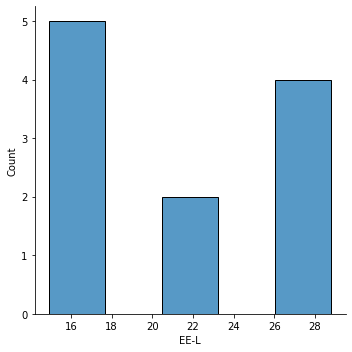

In [18]:
sns.displot(x='EE-L', data=run_scores)
plt.savefig('figures/task1-eel-dist.pdf')
plt.show()

In [19]:
run_tbl_df = run_score_full[['EE-R', 'EE-D', 'EE-L']].copy()
run_tbl_df['EE-L 95% CI'] = run_score_full.apply(lambda r: "(%.3f, %.3f)" % (r['EE-L.Lo'], r['EE-L.Hi']), axis=1)
run_tbl_df

,EE-R,EE-D,EE-L,EE-L 95% CI
run_name,,,,
PL_IRLab_05,4.933110,1.402916,21.383234,"(16.579, 28.293)"
PL_IRLab_07,5.278973,1.532708,20.821300,"(16.283, 28.089)"
RUN_task2,9.550783,4.155718,14.900690,"(12.303, 19.946)"
UoGTrDExpDisT2,3.745907,6.135564,28.490287,"(22.571, 37.548)"
UoGTrDRelDiT2,3.477031,5.589081,28.481557,"(22.366, 37.739)"
UoGTrDivPropT2,4.937192,7.100466,27.072620,"(21.098, 35.870)"
UoGTrLambT2,2.244660,3.464418,28.821635,"(22.799, 37.718)"
UoGTrRelT2,11.828052,9.460927,15.651362,"(13.057, 20.148)"
pl_control_0.6,8.809100,3.273330,15.501669,"(12.552, 20.477)"


In [20]:
run_tbl_df.sort_values('EE-L', ascending=True, inplace=True)
run_tbl_df

,EE-R,EE-D,EE-L,EE-L 95% CI
run_name,,,,
RUN_task2,9.550783,4.155718,14.900690,"(12.303, 19.946)"
pl_control_0.6,8.809100,3.273330,15.501669,"(12.552, 20.477)"
UoGTrRelT2,11.828052,9.460927,15.651362,"(13.057, 20.148)"
pl_control_0.8,8.665371,3.254971,15.770767,"(12.746, 21.251)"
pl_control_0.92,8.480203,3.148620,16.034751,"(12.820, 21.158)"
PL_IRLab_07,5.278973,1.532708,20.821300,"(16.283, 28.089)"
PL_IRLab_05,4.933110,1.402916,21.383234,"(16.579, 28.293)"
UoGTrDivPropT2,4.937192,7.100466,27.072620,"(21.098, 35.870)"
UoGTrDRelDiT2,3.477031,5.589081,28.481557,"(22.366, 37.739)"


In [21]:
run_tbl_fn = Path('figures/task2-runs.tex')
run_tbl = run_tbl_df.to_latex(float_format="%.4f", bold_rows=True, index_names=False)
run_tbl_fn.write_text(run_tbl)
print(run_tbl)

\begin{tabular}{lrrrl}
\toprule
{} &    EE-R &   EE-D &    EE-L &       EE-L 95\% CI \\
\midrule
\textbf{RUN\_task2      } &  9.5508 & 4.1557 & 14.9007 &  (12.303, 19.946) \\
\textbf{pl\_control\_0.6 } &  8.8091 & 3.2733 & 15.5017 &  (12.552, 20.477) \\
\textbf{UoGTrRelT2     } & 11.8281 & 9.4609 & 15.6514 &  (13.057, 20.148) \\
\textbf{pl\_control\_0.8 } &  8.6654 & 3.2550 & 15.7708 &  (12.746, 21.251) \\
\textbf{pl\_control\_0.92} &  8.4802 & 3.1486 & 16.0348 &  (12.820, 21.158) \\
\textbf{PL\_IRLab\_07    } &  5.2790 & 1.5327 & 20.8213 &  (16.283, 28.089) \\
\textbf{PL\_IRLab\_05    } &  4.9331 & 1.4029 & 21.3832 &  (16.579, 28.293) \\
\textbf{UoGTrDivPropT2 } &  4.9372 & 7.1005 & 27.0726 &  (21.098, 35.870) \\
\textbf{UoGTrDRelDiT2  } &  3.4770 & 5.5891 & 28.4816 &  (22.366, 37.739) \\
\textbf{UoGTrDExpDisT2 } &  3.7459 & 6.1356 & 28.4903 &  (22.571, 37.548) \\
\textbf{UoGTrLambT2    } &  2.2447 & 3.4644 & 28.8216 &  (22.799, 37.718) \\
\bottomrule
\end{tabular}



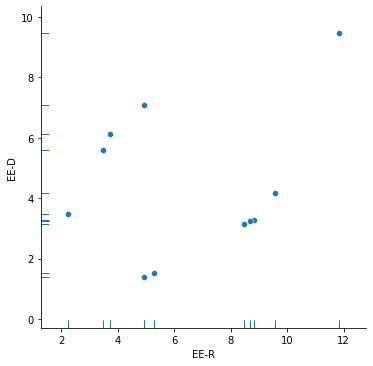

In [22]:
sns.relplot(x='EE-R', y='EE-D', data=run_scores)
sns.rugplot(x='EE-R', y='EE-D', data=run_scores)
plt.savefig('figures/task2-eed-eer.pdf')
plt.show()

## Per-Topic Stats

We need to return per-topic stats to each participant, at least for the score.

In [23]:
topic_stats = rank_exp.groupby('topic_id').agg(['mean', 'median', 'min', 'max'])
topic_stats

EE-L                                       EE-D            \
               mean     median        min        max      mean    median   
topic_id                                                                   
101       12.871998  13.813722   9.582406  16.624253  5.211536  2.983210   
103       18.211184  16.331314  12.444019  25.042557  3.997230  2.983210   
106       18.748906  17.074346   8.190457  27.133417  4.868676  2.983210   
108       17.738448  17.238511  11.186689  23.898508  3.917615  3.065990   
109       40.604369  42.958213  22.129796  56.682616  4.320261  3.834142   
113       15.901041  14.616473  10.141049  25.096067  4.912849  2.885524   
114       13.974984  13.061640  10.428272  21.022945  4.330128  3.359886   
115       13.473853  13.340910   9.503142  22.532676  4.067299  2.697173   
121       10.577441   8.914819   7.763187  15.367553  3.817925  1.839595   
122       26.464648  25.142625  13.161403  40.566063  5.178751  5.245069   
130       11.690142  11.254054   8.459638  18.111452  5.191717  5.845053   
134       11.622593  10.595471   8.632180  16.416689  4.480978  3.471364   
136        9.542885   7.754158   7.224677  13.404765  3.660606  2.617248   
138       10.955210  10.552141   8.217170  13.618661  3.650189  2.983210   
140       50.960062  50.717773  30.163612  72.213037  5.262420  5.665572   
141       14.680468  12.508795   7.533172  23.359250  4.843176  3.542778   
142       31.513485  32.424599  15.345451  45.479347  4.323355  3.132865   
143       10.578412   9.112138   8.148959  14.450792  3.247988  1.939242   
144       23.916740  23.751724  11.374333  36.134389  3.992154  3.782000   
147       22.287671  21.645631  11.343188  33.021559  3.932300  3.245539   
148       57.962985  58.692509  42.200783  74.483578  5.683388  5.472423   
149       29.442926  30.281935  20.718130  38.524458  5.357580  4.144341   
150       13.314734  12.844498   6.785931  18.805072  3.200112  2.278016   

                                    EE-R                                  
               min        max       mean     median       min        max  
topic_id                                                                  
101       1.451329  10.287514   5.481273   5.729841  3.130308   7.220019  
103       0.936037   9.460927   4.206279   3.649464  0.283583   8.730958  
106       1.106286  11.231416   6.209216   5.217264  1.165124  13.784566  
108       1.151249   9.460927   5.656082   4.534145  2.496983  11.703617  
109       1.062173   9.460927   9.291421   6.544893  1.177214  21.099041  
113       1.473626   9.727976   3.897491   3.986729  1.707542   6.204825  
114       1.885809   9.460927   5.781009   6.651622  1.583569   8.877603  
115       0.948001   9.460927   4.927235   4.631783  2.992210   9.407980  
121       1.207524   9.460927   4.017713   3.840104  2.205299   6.493350  
122       1.367115   9.460927   8.482114   7.349777  1.464566  17.274825  
130       1.050720   9.460927   5.035263   5.228493  1.851285   7.084139  
134       2.117512   9.460927   4.911161   5.015155  3.107569   7.733161  
136       1.009013   9.460927   3.786839   3.923979  1.786105   5.545584  
138       1.376509   9.460927   4.782261   4.376852  3.117046   7.626760  
140       1.724828   9.460927  12.155382  10.583846  1.067857  24.652861  
141       1.418162  12.184694   6.125672   5.734687  1.347308  12.008196  
142       1.042428   9.460927   8.490118   6.528689  0.837114  19.016202  
143       0.917649   9.460927   3.973636   4.091605  1.991503   7.820434  
144       1.182181   9.460927   7.113459   5.876767  0.818210  16.119049  
147       1.010082   9.460927   7.199001   6.267879  1.357512  15.435557  
148       1.888823   9.460927  14.972362  12.973181  6.528585  24.742233  
149       1.253940   9.460927   9.451987  10.812429  4.363439  14.511375  
150       1.000044   9.460927   4.494730   3.704565  1.680160  10.889540

Make final score analysis:

In [24]:
topic_range = topic_stats.loc[:, 'EE-L']
topic_range = topic_range.drop(columns=['mean'])
topic_range

,median,min,max
topic_id,,,
101,13.813722,9.582406,16.624253
103,16.331314,12.444019,25.042557
106,17.074346,8.190457,27.133417
108,17.238511,11.186689,23.898508
109,42.958213,22.129796,56.682616
113,14.616473,10.141049,25.096067
114,13.061640,10.428272,21.022945
115,13.340910,9.503142,22.532676
121,8.914819,7.763187,15.367553


And now we combine scores with these results to return to participants.

In [25]:
ret_dir = Path('results')
for system, runs in rank_exp.groupby('run_name'):
    aug = runs.join(topic_range).reset_index().drop(columns=['run_name'])
    fn = ret_dir / f'{system}.tsv'
    log.info('writing %s', fn)
    aug.to_csv(fn, sep='\t', index=False)

INFO:task1-eval:writing results\PL_IRLab_05.tsv
INFO:task1-eval:writing results\PL_IRLab_07.tsv
INFO:task1-eval:writing results\RUN_task2.tsv
INFO:task1-eval:writing results\UoGTrDExpDisT2.tsv
INFO:task1-eval:writing results\UoGTrDRelDiT2.tsv
INFO:task1-eval:writing results\UoGTrDivPropT2.tsv
INFO:task1-eval:writing results\UoGTrLambT2.tsv
INFO:task1-eval:writing results\UoGTrRelT2.tsv
INFO:task1-eval:writing results\pl_control_0.6.tsv
INFO:task1-eval:writing results\pl_control_0.8.tsv
INFO:task1-eval:writing results\pl_control_0.92.tsv
